In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import os,sys
import random
#import pydicom
import pylab
from skimage.transform import resize
import pathlib
import keras
import tensorflow as tf
from keras.applications.densenet import DenseNet121
from keras.layers import Input,Add, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

In [2]:
@tf.function
def DataSet():
    
    normal_train = './train/NORMAL/'
    pneumonia_train = './train/PNEUMONIA/'
    
    normal_test = './test/NORMAL/'
    pneumonia_test = './test/PNEUMONIA/'
    
    img_normal_train = os.listdir(normal_train)
    img_pneumonia_train = os.listdir(pneumonia_train)
    
    img_normal_test = os.listdir(normal_test)
    img_pneumonia_test = os.listdir(pneumonia_test)
        
    X_train = np.empty((len(img_normal_train) + len(img_pneumonia_train), 100, 100, 3))
    Y_train = np.empty((len(img_normal_train) + len(img_pneumonia_train), ))
    count = 0
    for img_name in img_normal_train:
        
        img_path = normal_train + img_name
        img = image.load_img(img_path, target_size=(100, 100))
        img = image.img_to_array(img) / 255.0
        
        X_train[count] = img
        Y_train[count] = np.array(0)
        count+=1
        
    for img_name in img_pneumonia_train:

        img_path = pneumonia_train + img_name
        img = image.load_img(img_path, target_size=(100, 100))
        img = image.img_to_array(img) / 255.0
        
        X_train[count] = img
        Y_train[count] = np.array(1)
        count+=1
        
    X_test = np.empty((len(img_normal_test) + len(img_pneumonia_test), 100, 100, 3))
    Y_test = np.empty((len(img_normal_test) + len(img_pneumonia_test), ))
    count = 0
    for img_name in img_normal_test:

        img_path = normal_test + img_name
        img = image.load_img(img_path, target_size=(100, 100))
        img = image.img_to_array(img) / 255.0
        
        X_test[count] = img
        Y_test[count] = np.array(0)
        count+=1
        
    for img_name in img_pneumonia_test:
        
        img_path = pneumonia_test + img_name
        img = image.load_img(img_path, target_size=(100, 100))
        img = image.img_to_array(img) / 255.0
        
        X_test[count] = img
        Y_test[count] = np.array(1)
        count+=1
        
    index = [i for i in range(len(X_train))]
    random.shuffle(index)
    X_train = X_train[index]
    Y_train = Y_train[index]
    
    index = [i for i in range(len(X_test))]
    random.shuffle(index)
    X_test = X_test[index]    
    Y_test = Y_test[index]

    return X_train,Y_train,X_test,Y_test


X_train,Y_train,X_test,Y_test = DataSet()
print('X_train shape : ',X_train.shape)
print('Y_train shape : ',Y_train.shape)
print('X_test shape : ',X_test.shape)
print('Y_test shape : ',Y_test.shape)

X_train shape :  (5216, 100, 100, 3)
Y_train shape :  (5216,)
X_test shape :  (624, 100, 100, 3)
Y_test shape :  (624,)


In [27]:
# Define the DenseNet model pre-loaded with imagenet weights with last layer set as false
input_shape = (100, 100, 3)
num_of_class=2
img_in = Input(input_shape)              
model = DenseNet121(include_top= False , 
                weights=None,    
                input_tensor= img_in, 
                input_shape= input_shape,
                pooling='avg') 

# The pre-trained model has classification output for 14 categories and hence Dense layer is defined with layer 14
x = model.output  
#x = GlobalAveragePooling2D()(x)
predictions = Dense(14, activation="sigmoid", name="DenseNet121")(x)    
model = Model(inputs=img_in, outputs=predictions)
print(model.summary())

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 106, 106, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [28]:
# Load pre-trained weights on similar dataset
model.load_weights("brucechou1983_CheXNet_Keras_0.3.0_weights.h5")
# Print the model summary
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 106, 106, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [29]:
# Remove the last dense layer of 14 classes and print the summary
#model.layers.pop()
predictions = Dense(2, activation='softmax')(model.layers[-2].output)
model2 = Model(inputs=img_in, outputs=predictions)
model2.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 106, 106, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [32]:
adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
model2.compile(optimizer=adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
print(model2.summary())

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 106, 106, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [7]:
base_dir = r'C:\Users\user\Desktop\chest-xray-classification'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

In [33]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255, 
                                       rotation_range=30, 
                                       width_shift_range=0.2, 
                                       height_shift_range=0.2,
                                       shear_range=0.2, 
                                       zoom_range=0.2, 
                                       horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)  # 請注意！驗證資料不應該擴充!!!

train_generator = train_datagen.flow_from_directory(
    train_dir,    # 目標目錄
    target_size=(100, 100), # 所有圖像大小調整成 100x100
    batch_size=16,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(100, 100),
    batch_size=16,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size = (100,100),
    batch_size=16, 
    class_mode="binary")

# 訓練
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, mode='min')

#EarlyStop=EarlyStopping(monitor='val_accuracy', patience=3, mode='max')

#Set Early stopping parameter and Reduce Learning rate on Plateau
callbacks_list = [EarlyStopping(monitor='val_accuracy',patience=3,),
                  ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,)]

#history = model2.fit(X_train, Y_train, batch_size=16, epochs=3, validation_data=(X_test,Y_test), callbacks=callbacks_list)
history = model2.fit_generator(train_generator, steps_per_epoch=326, epochs=5, validation_data=(X_test,Y_test), 
                               callbacks=callbacks_list)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/5
326/326 [==============================] - 482s 1s/step - loss: 0.2228 - accuracy: 0.9095 - val_accuracy: 0.7500 - val_loss: 0.9314 - lr: 0.0010
Epoch 2/5
326/326 [==============================] - 482s 1s/step - loss: 0.1465 - accuracy: 0.9446 - val_accuracy: 0.8798 - val_loss: 0.5944 - lr: 0.0010
Epoch 3/5
326/326 [==============================] - 554s 2s/step - loss: 0.1298 - accuracy: 0.9490 - val_accuracy: 0.6250 - val_loss: 3.1098 - lr: 0.0010
Epoch 4/5
326/326 [==============================] - 552s 2s/step - loss: 0.1163 - accuracy: 0.9584 - val_accuracy: 0.9038 - val_loss: 0.2130 - lr: 0.0010
Epoch 5/5
326/326 [==============================] - 558s 2s/step - loss: 0.1036 - accuracy: 0.9647 - val_accuracy: 0.9119 - val_loss: 0.3620 - lr: 0.0010


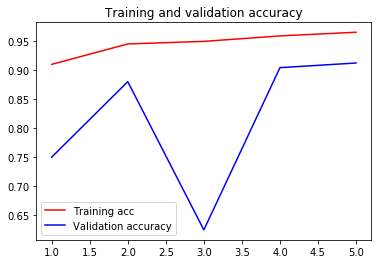

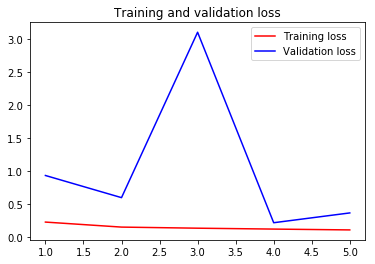

In [35]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
#plt.savefig('Model accuracy.png')

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
#plt.savefig('Model loss.png')